# Analysis

Exploratory analysis on detecting reocurring stock price decreases.

In [23]:
import pandas as pd
import importlib
from matplotlib import pyplot as plt
import numpy as np
from datetime import date
import polars as pl

import pattern_detector.utils as utils

### Load data

Data is found at https://finance.yahoo.com/quote/NRDY/history?filter=history

In [24]:
df = pd.read_csv("data/NRDY.csv")

print(df)


           Date    Open    High     Low   Close  Adj Close  Volume
0    2020-11-27   9.700   9.700   9.700   9.700      9.700     100
1    2020-11-30  10.250  10.270  10.250  10.270     10.270     400
2    2020-12-01  10.010  10.170   9.900  10.165     10.165   52800
3    2020-12-02  10.165  10.165  10.165  10.165     10.165       0
4    2020-12-03  10.670  10.670  10.590  10.590     10.590     600
..          ...     ...     ...     ...     ...        ...     ...
857  2024-04-26   2.650   2.835   2.620   2.760      2.760  899600
858  2024-04-29   2.770   2.820   2.660   2.710      2.710  700100
859  2024-04-30   2.670   2.680   2.580   2.590      2.590  560600
860  2024-05-01   2.610   2.660   2.530   2.560      2.560  900800
861  2024-05-02   2.630   2.660   2.480   2.640      2.640  826100

[862 rows x 7 columns]


### Cleaning data

Calculating change in stock price from close of one day to close of the next day.

In [25]:
importlib.reload(utils)

# df = utils.clean_df(df)
df = pl.from_pandas(df).select(
        pl.col("Date").cast(date).alias("date"), pl.col("Adj Close").alias("value")
    )
df = utils.convert_to_percentage(df)

df

date,value
date,f64
2020-11-30,0.058763
2020-12-01,-0.010224
2020-12-02,0.0
2020-12-03,0.04181
2020-12-04,-0.017941
…,…
2024-04-26,0.061538
2024-04-29,-0.018116
2024-04-30,-0.04428


### Pattern Analysis

Generating possible patterns and calculating their percentage of days the price decreased, the mean of the percent price change, and the standard deviation of the price change.

In [26]:
importlib.reload(utils)

dates = df["date"]
patterns = utils.generate_possible_patterns(dates)

summarization_dict = {"pattern": [], "days_decreased": [], "days_total": [], "mean": [], "stdev": [], 
                   "next_days_decreased": [], "next_mean": [], "next_stdev": []}
for pattern in patterns:
  days_decreased, mean, stdev = utils.summarize_pattern(pattern, df)
  days_total = len(pattern)

  next_days_decreased, next_mean, next_stdev = utils.summarize_pattern_next_day(pattern, df)

  summarization_dict["pattern"].append(pattern)
  summarization_dict["days_decreased"].append(days_decreased)
  summarization_dict["days_total"].append(days_total)
  summarization_dict["mean"].append(mean)
  summarization_dict["stdev"].append(stdev)
  summarization_dict["next_days_decreased"].append(next_days_decreased)
  summarization_dict["next_mean"].append(next_mean)
  summarization_dict["next_stdev"].append(next_stdev)

summarization_df = pd.DataFrame(summarization_dict)

summarization_df = summarization_df.dropna()
summarization_df

,pattern,days_decreased,days_total,mean,stdev,next_days_decreased,next_mean,next_stdev
0,"[2020-11-30, 2021-03-01, 2021-06-01, 2021-08-3...",6,14,0.015215,0.058144,5,0.024229,0.084865
1,"[2020-12-01, 2021-03-01, 2021-06-01, 2021-09-0...",5,14,0.025985,0.083139,4,-0.007554,0.026971
2,"[2020-12-02, 2021-03-02, 2021-06-02, 2021-09-0...",4,14,-0.007554,0.026971,7,-0.005244,0.035368
3,"[2020-12-03, 2021-03-03, 2021-06-03, 2021-09-0...",8,14,-0.015165,0.034902,6,0.011529,0.037853
4,"[2020-12-04, 2021-03-04, 2021-06-04, 2021-09-0...",9,14,-0.016676,0.030082,2,0.026705,0.038318
...,...,...,...,...,...,...,...,...
1244,[2024-04-29],1,1,-0.018116,0.000000,1,-0.044280,0.000000
1245,[2024-04-29],1,1,-0.018116,0.000000,1,-0.044280,0.000000
1246,[2024-04-29],1,1,-0.018116,0.000000,1,-0.044280,0.000000
1247,[2024-04-30],1,1,-0.044280,0.000000,1,-0.011583,0.000000


#### Cleaning summarizations

We need to remove patterns with less than 4 dates, or 1 year, as they do not have enough data points to show a pattern.


In [27]:
summarization_df = summarization_df[summarization_df["pattern"].apply(len) >= 6]
summarization_df

,pattern,days_decreased,days_total,mean,stdev,next_days_decreased,next_mean,next_stdev
0,"[2020-11-30, 2021-03-01, 2021-06-01, 2021-08-3...",6,14,0.015215,0.058144,5,0.024229,0.084865
1,"[2020-12-01, 2021-03-01, 2021-06-01, 2021-09-0...",5,14,0.025985,0.083139,4,-0.007554,0.026971
2,"[2020-12-02, 2021-03-02, 2021-06-02, 2021-09-0...",4,14,-0.007554,0.026971,7,-0.005244,0.035368
3,"[2020-12-03, 2021-03-03, 2021-06-03, 2021-09-0...",8,14,-0.015165,0.034902,6,0.011529,0.037853
4,"[2020-12-04, 2021-03-04, 2021-06-04, 2021-09-0...",9,14,-0.016676,0.030082,2,0.026705,0.038318
...,...,...,...,...,...,...,...,...
790,"[2023-01-30, 2023-05-01, 2023-07-31, 2023-10-3...",2,6,0.003912,0.016081,4,-0.026852,0.042504
791,"[2023-01-30, 2023-05-01, 2023-07-31, 2023-10-3...",3,6,-0.010689,0.024785,4,-0.019029,0.041313
792,"[2023-01-31, 2023-05-01, 2023-07-31, 2023-10-3...",4,6,-0.007192,0.025924,3,-0.012044,0.046278
793,"[2023-02-01, 2023-05-01, 2023-08-01, 2023-11-0...",3,6,0.002488,0.023965,1,0.005909,0.049806


#### Visualizations

Creating visualizations for the summarizations.

First, creating a histogram to visualize the distribution of days_decreased / days_total

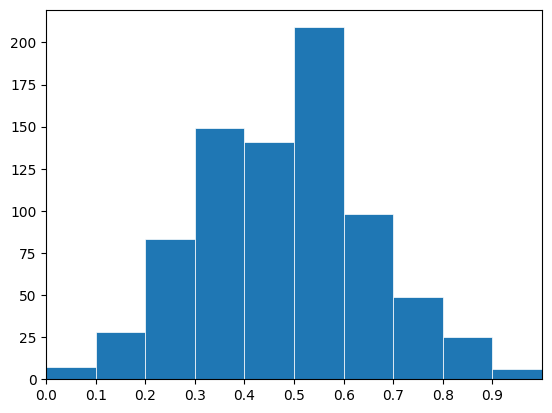

In [28]:
# organize data
x = (summarization_df["days_decreased"] / summarization_df["days_total"]).to_list()

# plot:
fig, ax = plt.subplots()

ax.hist(x, bins=10, linewidth=0.5, edgecolor="white")

ax.set(xlim=(0, 1), xticks=np.arange(0, 1, .1))

plt.show()

Results of this graph show that there are some patterns that have consistently decreases. However, this is expected due to probability. We need a way to differentiate between the real patterns and those that are random.

Next, we can visualize the correlation of means and percentage of days decreased. We expect to see a negative correlation. We can plot the real patterns in red to compare with the rest.

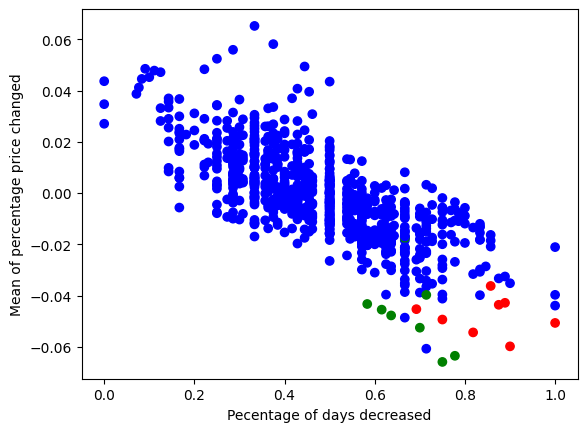

In [29]:
# real_pattern = [date.fromisoformat(x) for x in ["2021-02-16", "2021-05-17", "2021-08-16", "2021-11-15", "2022-02-15", "2022-05-16", "2022-08-15", "2022-11-15", "2023-02-15", "2023-05-15", "2023-08-15", "2023-11-15", "2024-02-15"]]
# real_pattern = [date.fromisoformat(x) for x in ["2021-02-16", "2021-05-17", "2021-08-16", "2021-11-16", "2022-02-16", "2022-05-16", "2022-08-16", "2022-11-16", "2023-02-16", "2023-05-16", "2023-08-16", "2023-11-16", "2024-02-16"]]
# real_pattern = [date.fromisoformat(x) for x in ["2021-02-17", "2021-05-17", "2021-08-17", "2021-11-17", "2022-02-17", "2022-05-17", "2022-08-17", "2022-11-17", "2023-02-17", "2023-05-17", "2023-08-17", "2023-11-17", "2024-02-17"]]
dates = df['date']

real_pattern = utils.generate_pattern_from_date(date.fromisoformat("2021-02-16"), dates)
secondary_pattern = utils.generate_pattern_from_date(date.fromisoformat("2021-02-17"), dates)

# organize data
x = (summarization_df["days_decreased"] / summarization_df["days_total"]).to_list()
y = summarization_df["mean"].to_list()

colors = ["r" if np.all([x in real_pattern for x in pattern]) else "g" if np.all([x in secondary_pattern for x in pattern]) else "b" for pattern in summarization_df["pattern"].to_list()]

# plot:
fig, ax = plt.subplots()
ax.scatter(x, y, c=colors)
ax.set_xlabel("Pecentage of days decreased")
ax.set_ylabel("Mean of percentage price changed")

plt.show()

The real patterns are in the bottom right, which shows that they are in fact good patterns, however there are some other patterns near them that will need to be removed.

#### Pattern Visualization

It would be helpful to be able to visualize how the patterns are occuring over time, in case they started at a later date.

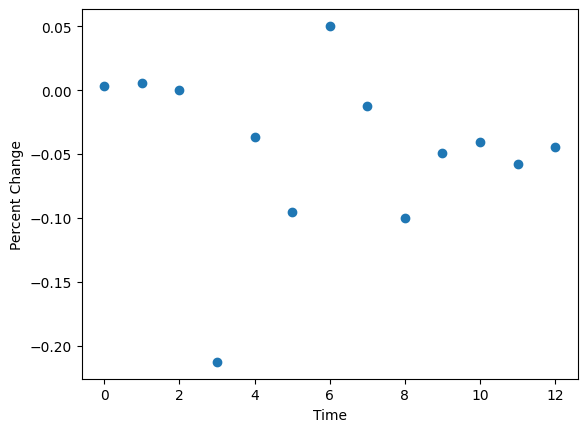

In [30]:
pattern_df = df.filter(pl.col("date").is_in(real_pattern))

# organize data
x = range(0, len(real_pattern))
y = pattern_df['value'].to_list()

# plot:
fig, ax = plt.subplots()
ax.scatter(x, y)
ax.set_xlabel("Time")
ax.set_ylabel("Percent Change")

plt.show()

From this plot, it appears as though the pattern didn't start until the 4th data point. This plot shows that the pattern has a fairly consistent decrease.

Let's see which patterns had the most days decreased.

In [31]:
# print(summarization_df.sort_values(by="days_decreased", ascending=False))
print(summarization_df.sort_values(by="mean", ascending=True).head(15))

                                               pattern  days_decreased  \
533  [2022-05-17, 2022-08-17, 2022-11-17, 2023-02-1...               6   
444  [2022-02-17, 2022-05-17, 2022-08-17, 2022-11-1...               7   
636  [2022-08-29, 2022-11-28, 2023-02-28, 2023-05-3...               5   
351  [2021-11-16, 2022-02-16, 2022-05-16, 2022-08-1...               9   
259  [2021-08-16, 2021-11-16, 2022-02-16, 2022-05-1...               9   
352  [2021-11-17, 2022-02-17, 2022-05-17, 2022-08-1...               7   
716  [2022-11-16, 2023-02-16, 2023-05-16, 2023-08-1...               6   
167  [2021-05-17, 2021-08-16, 2021-11-16, 2022-02-1...               9   
728  [2022-11-28, 2023-02-28, 2023-05-30, 2023-08-2...               4   
260  [2021-08-17, 2021-11-17, 2022-02-17, 2022-05-1...               7   
79   [2021-02-17, 2021-05-17, 2021-08-17, 2021-11-1...               8   
78   [2021-02-16, 2021-05-17, 2021-08-16, 2021-11-1...               9   
719  [2022-11-21, 2023-02-21, 2023-05-

It appears as though the price decrease is continuing into a second day. We want to see if this can differentiate from other patterns.

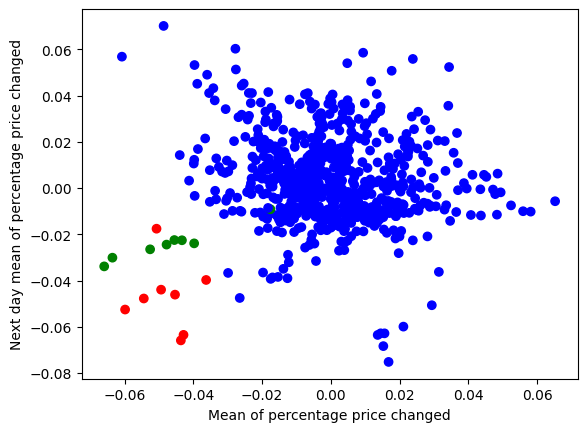

In [32]:
# organize data
x = summarization_df["mean"].to_list()
y = summarization_df["next_mean"].to_list()

colors = ["r" if np.all([x in real_pattern for x in pattern]) else "g" if np.all([x in secondary_pattern for x in pattern]) else "b" for pattern in summarization_df["pattern"].to_list()]

# plot:
fig, ax = plt.subplots()
ax.scatter(x, y, c=colors)
ax.set_xlabel("Mean of percentage price changed")
ax.set_ylabel("Next day mean of percentage price changed")

plt.show()

This appears to be a good metric for separating out the real patterns from the false. It could potentially be benificial to test for patterns with a period of multiple days repeating every quarter.

### Finding 'good' patterns

I need a way to separate out the good patterns from the bad, so that the program could find patterns without human judgement. First, I am trying using simple rules to judge whether a pattern is good.

In [33]:
importlib.reload(utils)

good_patterns = utils.find_good_patterns(df)

print([pattern[0] for pattern in good_patterns])

# [datetime.date(2021, 2, 16), datetime.date(2022, 2, 16), datetime.date(2022, 2, 17), datetime.date(2022, 4, 18)]


[datetime.date(2021, 2, 16), datetime.date(2021, 2, 18), datetime.date(2021, 5, 17), datetime.date(2021, 5, 18), datetime.date(2021, 8, 16), datetime.date(2021, 11, 16), datetime.date(2022, 2, 16), datetime.date(2022, 2, 17), datetime.date(2022, 2, 18), datetime.date(2022, 4, 18), datetime.date(2022, 5, 16), datetime.date(2022, 5, 17), datetime.date(2022, 5, 18)]


### Pruning the 'good' patterns

Many of the 'good' patterns are subsets of each other, or the following day of another 'good' pattern. I want to prune away these repetitive patterns.

In [35]:
importlib.reload(utils)

pruned_patterns = utils.prune_patterns(good_patterns)

for pattern in pruned_patterns:
    print(str(pattern[0]), len(pattern), utils.summarize_pattern(pattern, df), utils.summarize_pattern_next_day(pattern, df))


2021-02-16 13 (9, -0.04532540731774727, 0.06268495980926414) (9, -0.046120747974528545, 0.08256362467208343)
2022-04-18 9 (6, -0.02207622141441725, 0.022765696408178316) (7, -0.010699538543941586, 0.02615430877611169)


In [42]:
for pattern in good_patterns:
    if any([item.month == 2 for item in pattern]):
        print(pattern)

[datetime.date(2021, 2, 16), datetime.date(2021, 5, 17), datetime.date(2021, 8, 16), datetime.date(2021, 11, 16), datetime.date(2022, 2, 16), datetime.date(2022, 5, 16), datetime.date(2022, 8, 16), datetime.date(2022, 11, 16), datetime.date(2023, 2, 16), datetime.date(2023, 5, 16), datetime.date(2023, 8, 16), datetime.date(2023, 11, 16), datetime.date(2024, 2, 16)]
[datetime.date(2021, 2, 18), datetime.date(2021, 5, 18), datetime.date(2021, 8, 18), datetime.date(2021, 11, 18), datetime.date(2022, 2, 18), datetime.date(2022, 5, 18), datetime.date(2022, 8, 18), datetime.date(2022, 11, 18), datetime.date(2023, 2, 21), datetime.date(2023, 5, 18), datetime.date(2023, 8, 18), datetime.date(2023, 11, 20), datetime.date(2024, 2, 20)]
[datetime.date(2021, 5, 17), datetime.date(2021, 8, 16), datetime.date(2021, 11, 16), datetime.date(2022, 2, 16), datetime.date(2022, 5, 16), datetime.date(2022, 8, 16), datetime.date(2022, 11, 16), datetime.date(2023, 2, 16), datetime.date(2023, 5, 16), datetime.